# 🔍 LSTM-Flare Anomaly Detection Notebook
This notebook implements a custom LSTM autoencoder-based anomaly detection tool for the LSTM-Flare time series dataset.
It includes:
- Data preprocessing
- Sliding window creation
- LSTM Autoencoder model
- Anomaly detection
- Label-based evaluation (if labels available)

Author: *Pratahm Raj Mathur*

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
import seaborn as sns

plt.style.use('seaborn-darkgrid')

/var/folders/fs/d880vrvd1l5c_m6nhzkj2k_r0000gn/T/ipykernel_95977/2541451314.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [34]:
df = pd.read_csv('normalized_testing.csv')
df.head()

,NOAA,HARP,TOTUSJH,USFLUX,SAVNCPP,TOTUSJZ,ABSNJZH,TOTPOT,AREA_ACR,Cdec,...,MEANGBH,MEANJZD,Xhis1d,Xdec,Xhis,EPSX,EPSY,Bhis,Bdec,Bhis1d
0,0.0,0.0,0.005989,0.008768,0.005122,0.000341,0.009140,0.002733,0.007698,0.0,...,0.000000,0.487072,0.0,0.0,0.0,0.132061,0.800595,0.0,0.0,0.0
1,0.0,0.0,0.005419,0.007201,0.005283,0.001308,0.007514,0.000973,0.006364,0.0,...,0.064768,0.563488,0.0,0.0,0.0,0.097710,0.601190,0.0,0.0,0.0
2,0.0,0.0,0.006254,0.007224,0.009353,0.002533,0.008150,0.000836,0.007350,0.0,...,0.021092,0.838827,0.0,0.0,0.0,0.071374,0.651786,0.0,0.0,0.0
3,0.0,0.0,0.005578,0.005472,0.006561,0.000506,0.007409,0.000845,0.004865,0.0,...,0.034936,0.691031,0.0,0.0,0.0,0.072137,0.761905,0.0,0.0,0.0
4,0.0,0.0,0.007661,0.007046,0.004585,0.004011,0.006477,0.000000,0.003108,0.0,...,0.019762,0.603187,0.0,0.0,0.0,0.053817,0.767857,0.0,0.0,0.0


In [35]:
if 'timestamp' in df.columns:
    df = df.drop(columns=['timestamp'])

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

window_size = 60
def create_windows(data, window):
    return np.array([data[i:i+window] for i in range(len(data)-window)])

X = create_windows(data_scaled, window_size)
X.shape

(131, 60, 42)

In [36]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    RepeatVector(X.shape[1]),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X.shape[2]))
])

model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit(X, X, epochs=20, batch_size=32, validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 64)                27392     
                                                                 
 repeat_vector_5 (RepeatVec  (None, 60, 64)            0         
 tor)                                                            
                                                                 
 lstm_11 (LSTM)              (None, 60, 64)            33024     
                                                                 
 time_distributed_5 (TimeDi  (None, 60, 42)            2730      
 stributed)                                                      
                                                                 
Total params: 63146 (246.66 KB)
Trainable params: 63146 (246.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
4/4 [

5/5 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       131
           1       0.00      0.00      0.00         0

    accuracy                           0.95       131
   macro avg       0.50      0.47      0.49       131
weighted avg       1.00      0.95      0.97       131



/Users/prath/Desktop/NJIT/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prath/Desktop/NJIT/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prath/Desktop/NJIT/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


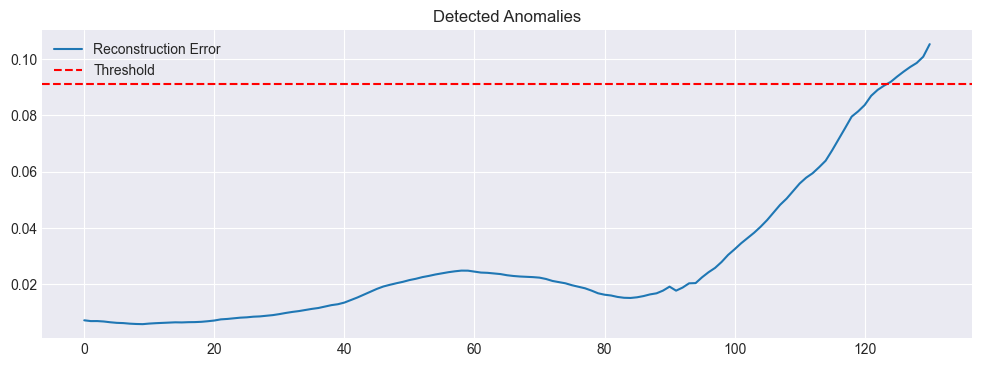

In [37]:
import pandas as pd
labels = pd.read_csv('labels.csv')
X_pred = model.predict(X)  
mse = np.mean((X - X_pred) ** 2, axis=(1, 2))  
threshold = np.percentile(mse, 95)
anomalies = mse > threshold  
labels_aligned = labels.iloc[window_size - 1:].reset_index(drop=True)
labels_aligned = labels_aligned.iloc[:len(anomalies)].reset_index(drop=True)
from sklearn.metrics import classification_report
print(classification_report(labels_aligned, anomalies.astype(int)))
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(mse, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title('Detected Anomalies')
plt.show()


In [38]:
labels = pd.read_csv('labels.csv')
labels_aligned = labels.iloc[window_size - 1:].reset_index(drop=True)
labels_aligned = labels_aligned.iloc[:len(anomalies)].reset_index(drop=True)
print(classification_report(labels_aligned, anomalies.astype(int)))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       131
           1       0.00      0.00      0.00         0

    accuracy                           0.95       131
   macro avg       0.50      0.47      0.49       131
weighted avg       1.00      0.95      0.97       131



/Users/prath/Desktop/NJIT/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prath/Desktop/NJIT/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prath/Desktop/NJIT/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
from sklearn.metrics import classification_report

# Generate the classification report as a string
report = classification_report(labels_aligned, anomalies.astype(int))

# Save to a text file
with open('classification_report.txt', 'w') as f:
    f.write(report)


/Users/prath/Desktop/NJIT/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prath/Desktop/NJIT/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prath/Desktop/NJIT/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
print("Finished")

Finished
